In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
# np.random.seed(13)
%load_ext autoreload
%autoreload 2

In [3]:
# Number of sources
r=5
# Number of mixtures
M=10
# Number of samples
N=500000
# SNR level
SNR=30 #dB
NoiseAmp=(10**(-SNR/20))*np.sqrt(r)

#Define number of sampling points
n_samples = N
#Degrees of freedom
df = 4

S = generate_correlated_copula_sources(rho = 0.7, df = 4, n_sources = r, size_sources = N , decreasing_correlation = True)
S = 2* S - 1
#######################################################
#              GENERATE MIXINGS                       #
#######################################################
# Generate Mxr random mixing from i.i.d N(0,1)
Hm=np.random.randn(M,r)
# Mixtures
HS=np.dot(Hm,S)
NoisePart=NoiseAmp*np.random.randn(HS.shape[0],HS.shape[1])
X=HS+NoisePart
SNRinp=10*np.log10(np.sum(np.var(HS,axis=1))/np.sum(np.var(NoisePart,axis=1)))

# Mean of Mixtures
mX=np.mean(X,axis=1).reshape((M,1))
# Covariance of Mixtures
Rxx=np.dot(X,X.T)/N-np.dot(mX,mX.T)
# Eigenvalue Decomposition
d,V=np.linalg.eig(Rxx)
D=np.diag(d)
#Sorting indexis for eigenvalues from large to small
ie=np.argsort(-d)
# Inverse square root of eigenvalues
ddinv=1/np.sqrt(d[ie[:r]])
# Prewhitining matrix
Wpre=np.dot(np.diag(ddinv),V[:,ie[:r]].T)/np.sqrt(12)
# Whitened Mixtures
H=np.dot(Wpre,X)

In [4]:
muW =2e-3
p = 1
bet = 30

debug_iteration_point = 500

model = OnlineWhiten(s_dim = r, x_dim = M, muW = muW, p = p, bet = bet)

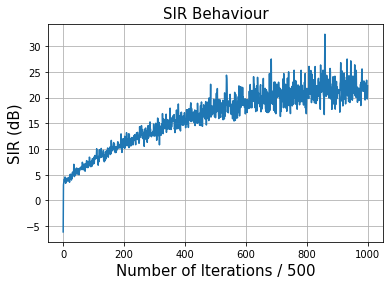

100%|█████████████████████████████████| 500000/500000 [04:14<00:00, 1962.91it/s]


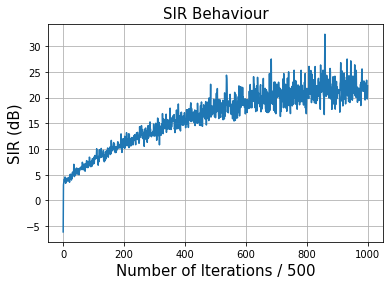

In [5]:
model.fit_batch_whiten(X = X, Rxx = Rxx, n_epochs = 1, neural_dynamic_iterations = 150, neural_lr_start = .1, 
                       neural_lr_stop = 1e-3, shuffle = True, required_SIR = 90,
                       debug_iteration_point = debug_iteration_point, plot_in_jupyter = True)

In [6]:
display_matrix(np.corrcoef(X))

<IPython.core.display.Math object>

In [7]:
display_matrix(np.corrcoef(model.Winv @ X))

<IPython.core.display.Math object>